In [3]:
import os
import cv2
import time
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from PIL import Image
from IPython.display import display
from sklearn.model_selection import train_test_split, KFold
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
from torchvision.models import resnet18, ResNet18_Weights
from captum.attr import LayerGradCam

from torch.utils.tensorboard import SummaryWriter

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f'Random seed set as {seed}')

In [43]:
current_directory = os.getcwd()
image_directory = os.path.join(current_directory, 'CodingChallenge_v2', 'imgs')
csv_file = os.path.join(current_directory, 'CodingChallenge_v2', 'car_imgs_4000.csv')

df = pd.read_csv(csv_file)
csv_filenames = df['filename'].tolist()
#print(len(csv_filenames), csv_filenames)

image_files = os.listdir(image_directory)
#print(len(image_files), image_files)

missing_images = [file for file in csv_filenames if file not in image_files]
extra_images = [file for file in image_files if file not in csv_filenames]

if missing_images:
    print(f'Missing images (present in csv but not in imgs): {missing_images}')
else:
    print('No missing images.')

if extra_images:
    print(f'Extra images (present in imgs but not in csv): {extra_images}')
else:
    print('No extra images.')

No missing images.
No extra images.


In [6]:
mean_dataset = [0.485, 0.456, 0.406]
std_dataset = [0.229, 0.224, 0.225]
random_seed = 47
input_dim = 224
number_splits = 5
selected_fold = 1
classes = 2
test_percentage = 0.15
batch_size = 32
learning_rate = 0.001
weight_decay = 0
epochs = 100
patience = 7
delta = 0.0001

**Parameter Erklärungen**

- Normalisieren der Bilder mit Mittelwert und Standartabweichung des ImageNet Datensatzes
- Random Seed zur Reproduzierbarkeit
- Reduzierung der Dimension von 674 x 506 auf 224 x 224 zum Einsetzen von Vortrainierten Neuronalen Netzen
- 5-fold Kreuzvalidierung um die Performance des Modelles besser evaluieren zu können
- Kleine bis Moderate Batchgröße von 32 um Abhängigkeit von den selben features zu reduzieren aber dennoch stabileres Training zu ermöglichen (evtl. sogar weiter auf 16 reduzieren)
- Learningrate mit 0.001 ist guter Startpunkt für den Adam Optimizer (Reduzieren bzw. erhöhen von einer Dekade bei Hyperparametersuche)
- Kein weight decay am Anfang falls Modell nicht overfittet
- Patience von 7 und delta von 0.0001 als Early Stopping Kriterium um zu verhindern, dass das Modell für alle 100 epochen trainiert wenn es overfittet

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
set_seed(random_seed)

cpu
Random seed set as 47


In [8]:
train_df, test_df = train_test_split(df, test_size=test_percentage, random_state=random_seed)

print(f"Train DataFrame length: {len(train_df)}")
display(train_df)

print(f"Test DataFrame length: {len(test_df)}")
display(test_df)

Train DataFrame length: 3400


filename  perspective_score_hood  \
3327  d7fbc8d0-78ba-42c9-b9d8-bee13670a6f2.jpg                0.000000   
2674  5e4325fd-0283-4487-ba6d-e1e478c2627a.jpg                0.364074   
856   7c65d8e4-2f71-4359-b05d-0aa5a80ece1a.jpg                0.000000   
540   e7c9d57f-5fb7-4a32-871b-7f9e17d72ec2.jpg                0.000000   
124   14424838-cbfb-41a3-a671-b10012fce59c.jpg                0.282298   
...                                        ...                     ...   
2632  2335e9de-2b43-4217-a9be-04518c7a3a18.jpg                0.000000   
3336  b9d5bd63-bb69-46a1-aa5f-8168bb4c2890.jpg                0.000000   
2375  9348aaaa-de05-4387-9bc0-2994c92728e5.jpg                0.174932   
1926  47f8b968-ccae-46d0-9381-93ea74522091.jpg                0.901693   
1159  a9a864d3-dcba-4759-8069-6a1e7e7932ec.jpg                0.071383   

      perspective_score_backdoor_left  
3327                         0.000000  
2674                         0.250305  
856                          0.905665  
540                          0.709991  
124                          0.802658  
...                               ...  
2632                         0.904439  
3336                         0.000000  
2375                         0.000000  
1926                         0.000000  
1159                         0.272805  

[3400 rows x 3 columns]

Test DataFrame length: 600


filename  perspective_score_hood  \
1568  798fed8b-4b87-4277-986e-15d44d216b45.jpg                0.000000   
648   8fd4c197-6509-4a2e-951c-1f0ae2d76e21.jpg                0.831004   
3616  d5cb7818-b592-46a7-8d0b-771576f081e3.jpg                0.000000   
3695  f1dc308e-41eb-4d1b-ae75-9ed6c1ee4a2c.jpg                0.000000   
2207  c6a256b9-d799-431a-9b30-55ae4946613f.jpg                0.901666   
...                                        ...                     ...   
3054  a03d5bbd-5789-41bd-8432-18d1ac4c9e73.jpg                0.000000   
1585  165d1a5b-06e2-41c8-939a-1ea0639f0dba.jpg                0.916585   
1606  c2a07ed9-d664-4fa0-8e66-9781f9f8f6bd.jpg                0.903132   
644   7cc0f853-0f4b-4b4e-98e8-5d29c75326e4.jpg                0.000000   
3601  43be5401-db67-44cf-92f8-6fb58e585a43.jpg                0.000000   

      perspective_score_backdoor_left  
1568                         0.917711  
648                          0.000000  
3616                         0.000000  
3695                         0.000000  
2207                         0.536348  
...                               ...  
3054                         0.000000  
1585                         0.067614  
1606                         0.000000  
644                          0.561009  
3601                         0.000000  

[600 rows x 3 columns]

In [9]:
kf = KFold(n_splits=number_splits, shuffle=True, random_state=random_seed)
train_index, val_index = list(kf.split(train_df))[selected_fold - 1]

train_fold = train_df.iloc[train_index]
val_fold = train_df.iloc[val_index]

print(f"Training Fold length: {len(train_fold)}")
display(train_fold)

print(f"Validation Fold length: {len(val_fold)}")
display(val_fold)

Training Fold length: 2720


filename  perspective_score_hood  \
540   e7c9d57f-5fb7-4a32-871b-7f9e17d72ec2.jpg                0.000000   
124   14424838-cbfb-41a3-a671-b10012fce59c.jpg                0.282298   
190   e5a7db15-d30f-4186-ae14-895d30b826f6.jpg                0.000000   
34    b929c9c2-1967-4119-a446-a7f3ce72db8e.jpg                0.260618   
1232  663d79d7-cc7c-4aa7-8b23-1c03934c1f08.jpg                0.000000   
...                                        ...                     ...   
2632  2335e9de-2b43-4217-a9be-04518c7a3a18.jpg                0.000000   
3336  b9d5bd63-bb69-46a1-aa5f-8168bb4c2890.jpg                0.000000   
2375  9348aaaa-de05-4387-9bc0-2994c92728e5.jpg                0.174932   
1926  47f8b968-ccae-46d0-9381-93ea74522091.jpg                0.901693   
1159  a9a864d3-dcba-4759-8069-6a1e7e7932ec.jpg                0.071383   

      perspective_score_backdoor_left  
540                          0.709991  
124                          0.802658  
190                          0.232265  
34                           0.000000  
1232                         0.905539  
...                               ...  
2632                         0.904439  
3336                         0.000000  
2375                         0.000000  
1926                         0.000000  
1159                         0.272805  

[2720 rows x 3 columns]

Validation Fold length: 680


filename  perspective_score_hood  \
3327  d7fbc8d0-78ba-42c9-b9d8-bee13670a6f2.jpg                0.000000   
2674  5e4325fd-0283-4487-ba6d-e1e478c2627a.jpg                0.364074   
856   7c65d8e4-2f71-4359-b05d-0aa5a80ece1a.jpg                0.000000   
2804  7c2ca6ee-3fdd-47cb-8b0b-f5198ce61658.jpg                0.566804   
3164  f84c7e33-adfd-4ba6-807e-bd9c581de67e.jpg                0.000000   
...                                        ...                     ...   
1756  40e3aaad-bd0f-4204-ad20-ffd5252ec00d.jpg                0.900693   
2121  e1e2599a-f0ba-4f5c-b37a-45d263c073ff.jpg                0.000000   
2729  57c4ba0f-0a06-4669-a58f-b471772d2e63.jpg                0.000000   
2733  fc708b2e-8cc8-42fc-8e0b-fb5260ccf46b.jpg                0.906013   
3095  d988a016-2700-45fd-a9c0-4c07555a01f7.jpg                0.000000   

      perspective_score_backdoor_left  
3327                         0.000000  
2674                         0.250305  
856                          0.905665  
2804                         0.000000  
3164                         0.000000  
...                               ...  
1756                         0.571049  
2121                         0.751550  
2729                         0.788148  
2733                         0.585677  
3095                         0.000000  

[680 rows x 3 columns]

In [10]:
data_transforms = {
    'train': v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Resize(size=(input_dim, input_dim), antialias=True),
        #v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        #v2.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 1.0)),
        #v2.RandomAdjustSharpness(sharpness_factor=1.5, p=0.2),
        #v2.RandomAutocontrast(p=0.1),
        v2.Normalize(mean=mean_dataset, std=std_dataset)]),

    'val': v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Resize(size=(input_dim, input_dim), antialias=True),
        v2.Normalize(mean=mean_dataset, std=std_dataset)]),

    'test': v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Resize(size=(input_dim, input_dim), antialias=True),
        v2.Normalize(mean=mean_dataset, std=std_dataset)])}

In [11]:
class CarDataset(Dataset):
    def __init__(self, imgs_dir, labels, transform=None):
        self.img_labels = labels
        self.imgs_dir = imgs_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.imgs_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path).convert(mode='RGB')
        if self.transform:
            image = self.transform(image)
        label = self.img_labels.iloc[idx, 1:].values.astype(float)
        label = torch.tensor(label, dtype=torch.float32)
        return image, label


In [12]:
image_datasets = {
    'train': CarDataset(
        imgs_dir=image_directory,
        labels=train_fold,
        transform=data_transforms['train']),

    'val': CarDataset(
        imgs_dir=image_directory,
        labels=val_fold,
        transform=data_transforms['val']),

    'test': CarDataset(
        imgs_dir=image_directory,
        labels=test_df,
        transform=data_transforms['test'])}

In [13]:
dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ['train', 'val', 'test']}

dataset_sizes = {
    x: len(image_datasets[x]) 
    for x in ['train', 'val', 'test']}

In [14]:
def visualize_images(dataloader, num_images=6):
    images, labels = next(iter(dataloader))
    images = images.numpy()
    mean_dataset_numpy = np.array(mean_dataset)
    std_dataset_numpy = np.array(std_dataset)
    images = images * std_dataset_numpy[None, :, None, None] + mean_dataset_numpy[None, :, None, None]
    images = np.clip(images, 0, 1)
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].transpose(1, 2, 0))
        plt.title(f'Labels: {labels[i].numpy()}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

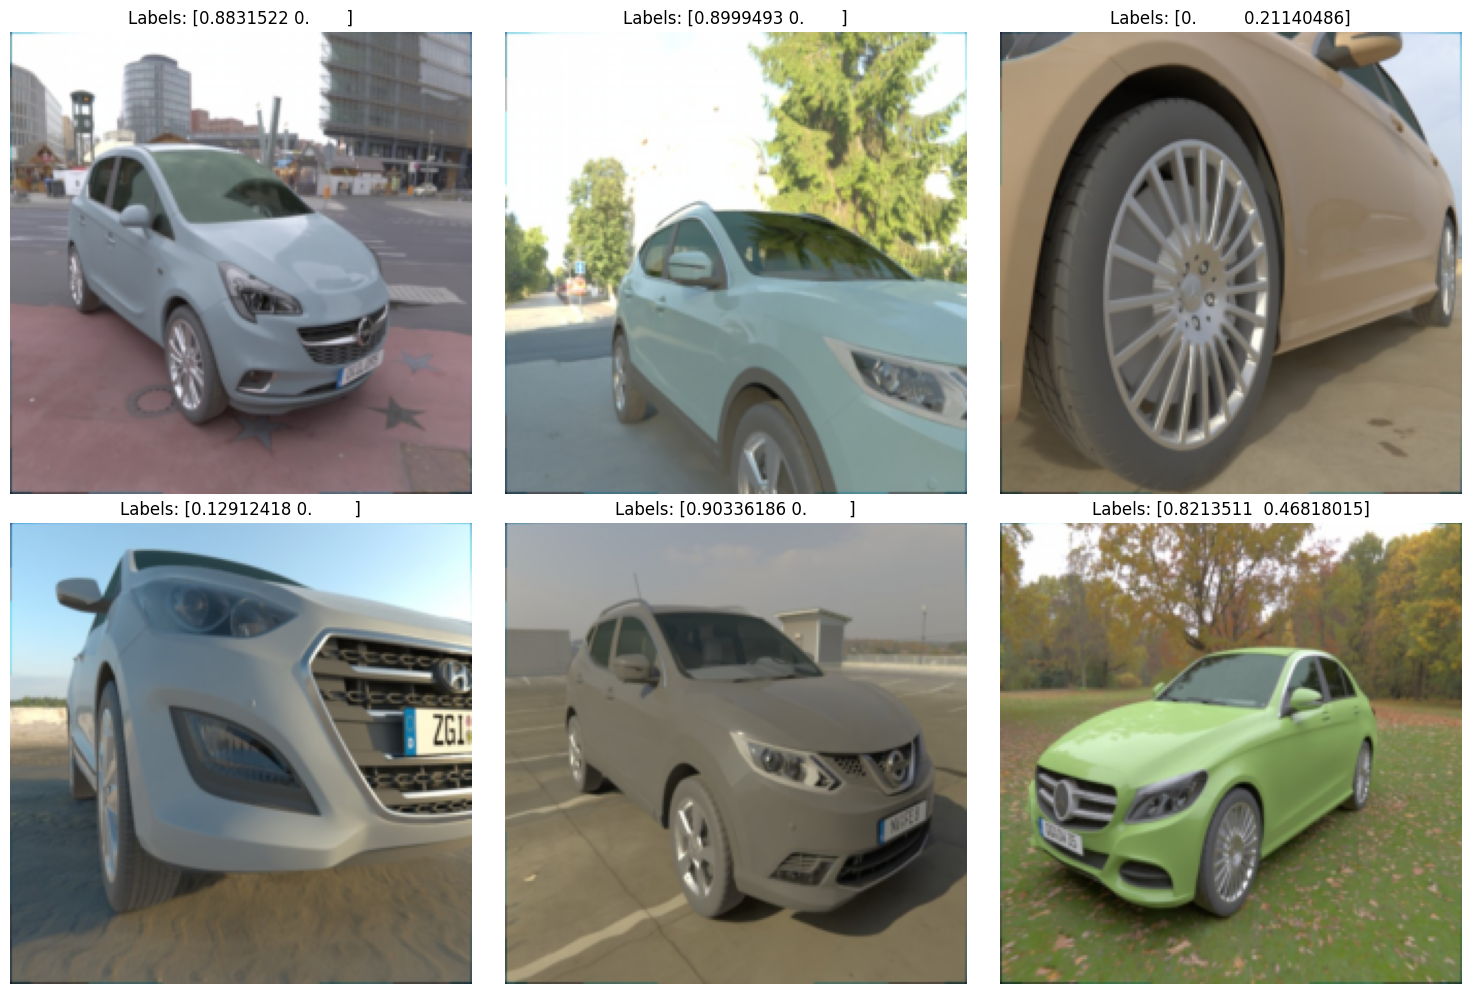

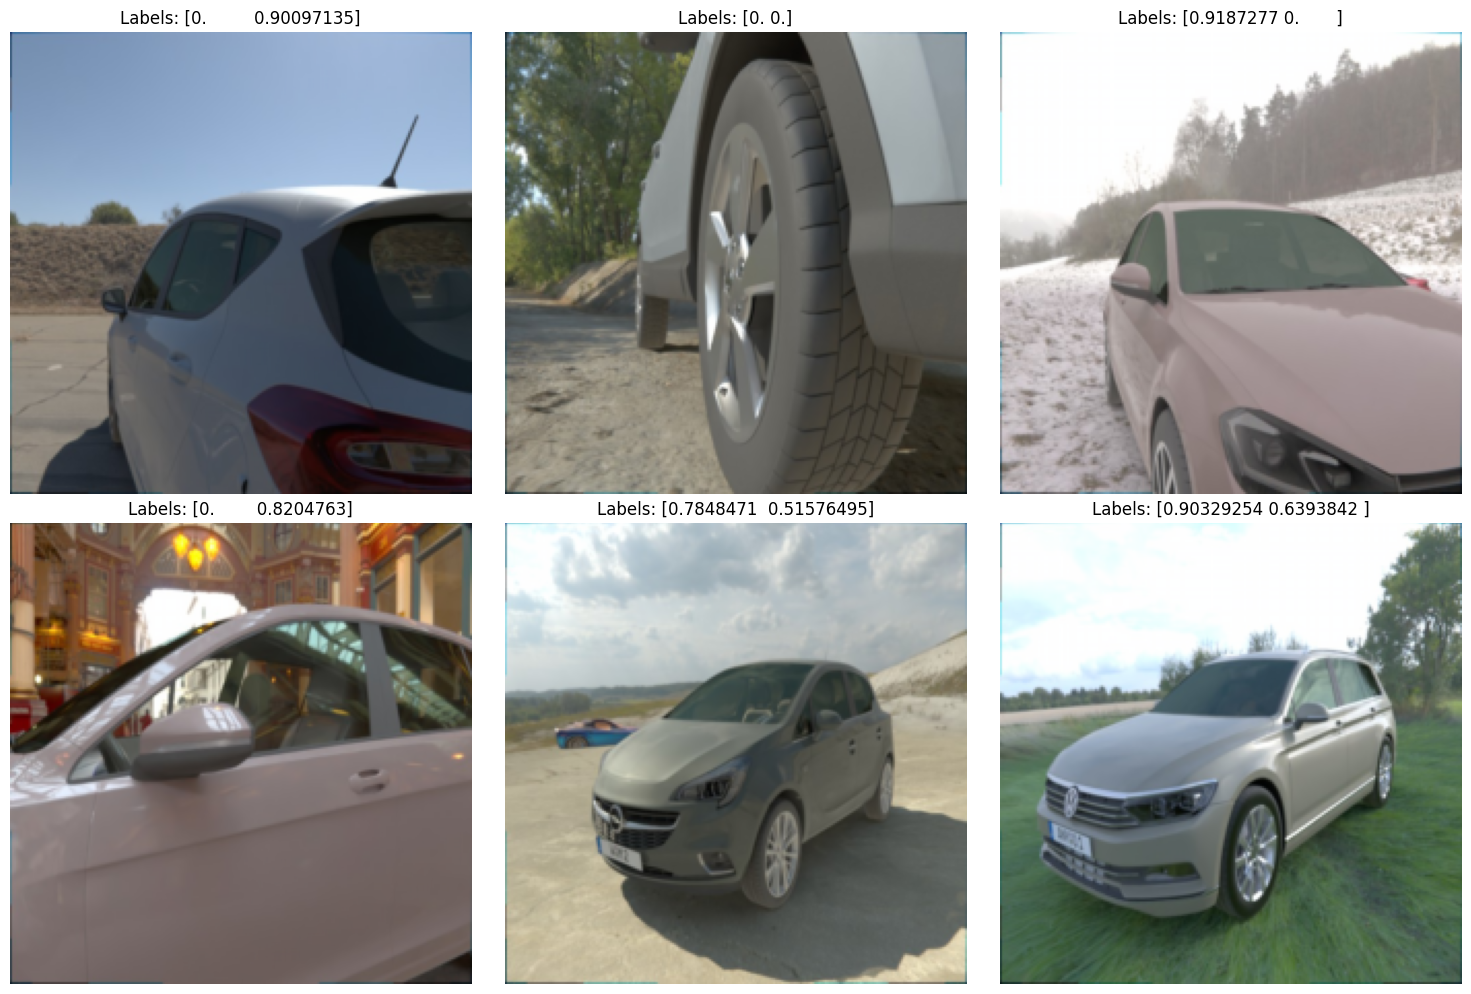

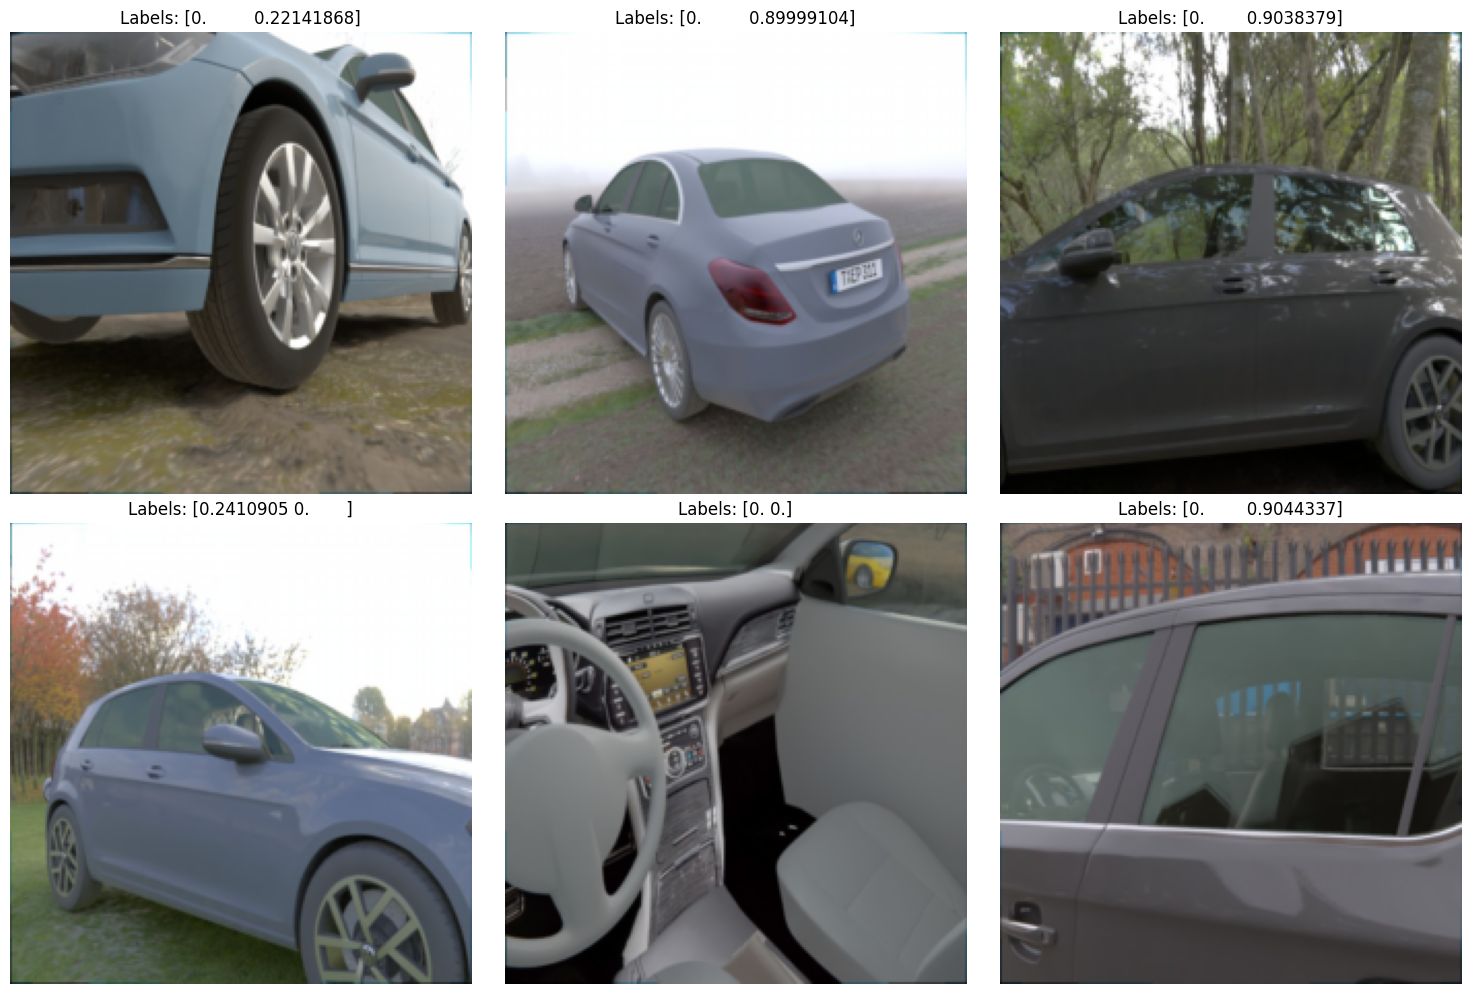

In [15]:
visualize_images(dataloaders['train'], num_images=6)
visualize_images(dataloaders['val'], num_images=6)
visualize_images(dataloaders['test'], num_images=6)

In [16]:
original_model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
print(original_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
class CarNet(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.features = nn.Sequential(*list(base_model.children())[:-1])
        number_features = base_model.fc.in_features
        self.regressor = nn.Sequential(
            nn.Linear(number_features, classes),
            nn.Sigmoid())
    
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.regressor(x)
        return x

In [18]:
model = CarNet(original_model).to(device)
print(model)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

CarNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

**Netzwerk, Objective und Optimierer Erklärungen**

- Convolutional Neural Network (CNN): State-of-the-art für verarbeitung von Images (Lernen von lokalen Strukturen)
- Auf ImageNet Vortrainiertes Netzwerk: Fähigkeit low- bis mid-level features zu extrahieren (z. B. Ecken und Kanten sowie bestimmte Formen), welche sich wenig zwischen unterschiedlichen Bilddatensätzen unterscheiden -> Beschleunigt Training und verbessert Generalisierungsfähigkeit (Sinnvoll bei kleineren Datensätzen)
- ResNet18: Parametereffizienter im Vergleich zu VGG und tieferen ResNets. Tief genug um komplexe high-level features für Motorhaube und Linke Hintertür zu lernen
- CarNet: Anpassen des ResNet18 auf eigenen use-case (Ersetzen des vorhandenen FC layers mit neuen FC layer mit 2 outputs [Motorhaube und Linke Hintertür]. Sigmoid Aktivierungsfunktion um voneinander unabhängige Werte zwischen 0 und 1 zu bekommen)
- Mean Squared Error (MSE) als Objective: Geeignet für Regressionsaufgaben. Größere Abweichungen werden stärker bestraft 
- Adam Optimizer: Beliebter Optimierungsalgorithmus aufgrund der adaptiven Learning rate (berechnet aus beiden Momentum Werten) -> Schnellere Konvergenz im vergleich zu SGD

In [19]:
class EarlyStopping:
    def __init__(self, val_loss_best, patience, delta):
        self.val_loss_best = val_loss_best
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss > self.val_loss_best - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.val_loss_best = val_loss
            self.counter = 0

In [20]:
param_logs_name = 'ResNet18' + '_NS' + str(number_splits) + '_SF' + str(selected_fold) 
+ '_B' + str(batch_size) + '_LR' + str(learning_rate) + '_WD' + str(weight_decay) 
+ '_RS' + str(random_seed) + '_E' + str(epochs) + '_P' + str(patience) + '_D' + str(delta)

In [174]:
writer = SummaryWriter('tf_logs/' + param_logs_name)
val_loss_best = 1e10
early_stopping = EarlyStopping(val_loss_best, patience, delta)
since = time.time()

for epoch in range(epochs):
    train_loss = []
    all_train_outputs = []
    all_train_labels = []
    
    val_loss = []
    all_val_outputs = []
    all_val_labels = []
    
    print(f'Epoch {epoch + 1}/{epochs}')
    
    model.train()
    for i, (inputs, labels) in enumerate(dataloaders['train']):
        optimizer.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item())
        outputs_np = outputs.detach().cpu().numpy()
        labels_np = labels.cpu().numpy()
        all_train_outputs.append(outputs_np)
        all_train_labels.append(labels_np)
    
    all_train_outputs = np.concatenate(all_train_outputs, axis=0)
    all_train_labels = np.concatenate(all_train_labels, axis=0)
    
    train_loss_mean = np.mean(train_loss)
    train_hood_mae = np.abs(all_train_outputs[:, 0] - all_train_labels[:, 0]).mean()
    train_backdoor_left_mae = np.abs(all_train_outputs[:, 1] - all_train_labels[:, 1]).mean()
    train_hood_rmse = np.sqrt(((all_train_outputs[:, 0] - all_train_labels[:, 0]) ** 2).mean())
    train_backdoor_left_rmse = np.sqrt(((all_train_outputs[:, 1] - all_train_labels[:, 1]) ** 2).mean())
    
    writer.add_scalar('Train/Loss', train_loss_mean, epoch)
    writer.add_scalar('Train/Hood_MAE', train_hood_mae, epoch)
    writer.add_scalar('Train/Backdoor_Left_MAE', train_backdoor_left_mae, epoch)
    writer.add_scalar('Train/Hood_RMSE', train_hood_rmse, epoch)
    writer.add_scalar('Train/Backdoor_Left_RMSE', train_backdoor_left_rmse, epoch)
    
    print(f'Train Loss: {train_loss_mean:.4f}')
    print(f'Hood MAE: {train_hood_mae:.4f}, Backdoor Left MAE: {train_backdoor_left_mae:.4f}')
    print(f'Hood RMSE: {train_hood_rmse:.4f}, Backdoor Left RMSE: {train_backdoor_left_rmse:.4f}')
    
    model.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss.append(loss.item())
            outputs_np = outputs.cpu().numpy()
            labels_np = labels.cpu().numpy()
            all_val_outputs.append(outputs_np)
            all_val_labels.append(labels_np)
    
    all_val_outputs = np.concatenate(all_val_outputs, axis=0)
    all_val_labels = np.concatenate(all_val_labels, axis=0)
    
    val_loss_mean = np.mean(val_loss)
    val_hood_mae = np.abs(all_val_outputs[:, 0] - all_val_labels[:, 0]).mean()
    val_backdoor_left_mae = np.abs(all_val_outputs[:, 1] - all_val_labels[:, 1]).mean()
    val_hood_rmse = np.sqrt(((all_val_outputs[:, 0] - all_val_labels[:, 0]) ** 2).mean())
    val_backdoor_left_rmse = np.sqrt(((all_val_outputs[:, 1] - all_val_labels[:, 1]) ** 2).mean())
    
    writer.add_scalar('Validation/Loss', val_loss_mean, epoch)
    writer.add_scalar('Validation/Hood_MAE', val_hood_mae, epoch)
    writer.add_scalar('Validation/Backdoor_Left_MAE', val_backdoor_left_mae, epoch)
    writer.add_scalar('Validation/Hood_RMSE', val_hood_rmse, epoch)
    writer.add_scalar('Validation/Backdoor_Left_RMSE', val_backdoor_left_rmse, epoch)
    
    print(f'Validation Loss: {val_loss_mean:.4f}')
    print(f'Hood MAE: {val_hood_mae:.4f}, Backdoor Left MAE: {val_backdoor_left_mae:.4f}')
    print(f'Hood RMSE: {val_hood_rmse:.4f}, Backdoor Left RMSE: {val_backdoor_left_rmse:.4f}')
    
    if val_loss_mean < val_loss_best:
        val_loss_best = val_loss_mean
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss_mean,
        }, 'params/' + param_logs_name + '.pt')
    
    print('-' * 35)
    
    early_stopping(val_loss_mean)
    if early_stopping.early_stop:
        print(f"Early stopping at epoch {epoch + 1}")
        break

time_elapsed = time.time() - since
print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')


Epoch 1/100
Train Loss: 0.0477
Hood MAE: 0.1091, Backdoor Left MAE: 0.1485
Hood RMSE: 0.1964, Backdoor Left RMSE: 0.2386
Validation Loss: 0.0295
Hood MAE: 0.0791, Backdoor Left MAE: 0.1155
Hood RMSE: 0.1405, Backdoor Left RMSE: 0.2012
-----------------------------------
Epoch 2/100
Train Loss: 0.0188
Hood MAE: 0.0688, Backdoor Left MAE: 0.0881
Hood RMSE: 0.1160, Backdoor Left RMSE: 0.1552
Validation Loss: 0.0209
Hood MAE: 0.0679, Backdoor Left MAE: 0.0855
Hood RMSE: 0.1101, Backdoor Left RMSE: 0.1627
-----------------------------------
Epoch 3/100
Train Loss: 0.0118
Hood MAE: 0.0559, Backdoor Left MAE: 0.0663
Hood RMSE: 0.0979, Backdoor Left RMSE: 0.1182
Validation Loss: 0.0224
Hood MAE: 0.0584, Backdoor Left MAE: 0.0946
Hood RMSE: 0.0993, Backdoor Left RMSE: 0.1902
-----------------------------------
Epoch 4/100
Train Loss: 0.0081
Hood MAE: 0.0447, Backdoor Left MAE: 0.0556
Hood RMSE: 0.0759, Backdoor Left RMSE: 0.1021
Validation Loss: 0.0142
Hood MAE: 0.0517, Backdoor Left MAE: 0.072

**Train Progress Tensorboard**

<img src="screenshots/tensorboard_train.png" alt="Tensorboard_Progress_Train" style="width: 800px;"/>

**Validation Progress Tensorboard**

<img src="screenshots/tensorboard_val.png" alt="Tensorboard_Progress_Validation" style="width: 800px;"/>

- Geringster Validation Loss (MSE) nach 18 Epochen
- Early Stopping beendet Training nach 18 + 7 Epochen (Trainings Loss sinkt weiter + Validation Loss beginnt anzusteigen -> Overfitting)
- Trainings Loss geringer als Validation Loss (Nicht optimale Generalisierbarkeit auf Validierungsdaten)
- Methoden zur Verbesserung der Generalisierbarkeit (Data Augmentation, Weight Decay, Dropout, ...)
- Nächste Schritte: Durchführen der Experimente für restliche k-Splits -> Optimieren der Hyperparameter und Methoden zur Reduktion von Overfitting (z. B. Mit globalen Optimierungsalgorithmen wie Grid Search, Genetic Algorithms, PSO, ...)
- Evtl. auch Einsatz von Tieferen Vortrainierten CNNs (z. B. ResNet156) sowie Ensemble Models (Kombination von unterschiedlichen Modellarchitekturen)

In [21]:
test_model = model
checkpoint = torch.load('params/' + param_logs_name + '.pt', weights_only=False)
test_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [22]:
all_outputs = []
all_labels = []

test_model.eval()
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['test']):
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = test_model(inputs)
        loss = criterion(outputs, labels)

        outputs_np = outputs.cpu().numpy()
        labels_np = labels.cpu().numpy()

        all_outputs.append(outputs_np)
        all_labels.append(labels_np)

all_outputs = np.concatenate(all_outputs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

test_hood_mae = np.abs(all_outputs[:, 0] - all_labels[:, 0]).mean()
test_backdoor_left_mae = np.abs(all_outputs[:, 1] - all_labels[:, 1]).mean()
test_hood_rmse = np.sqrt(((all_outputs[:, 0] - all_labels[:, 0]) ** 2).mean())
test_backdoor_left_rmse = np.sqrt(((all_outputs[:, 1] - all_labels[:, 1]) ** 2).mean())

print(f'Hood MAE: {test_hood_mae:.4f}, Backdoor Left MAE: {test_backdoor_left_mae:.4f}')
print(f'Hood RMSE: {test_hood_rmse:.4f}, Backdoor Left RMSE: {test_backdoor_left_rmse:.4f}')

Hood MAE: 0.0325, Backdoor Left MAE: 0.0431
Hood RMSE: 0.0674, Backdoor Left RMSE: 0.0955


**Ergebnisse nach 25 Epochen auf dem Testset**

| Metric                | Hood   | Backdoor Left |
|-----------------------|--------|---------------|
| Mean Average Error (MAE)  | 0.0325 | 0.0431        |
| Root Mean Squared Error (RMSE) | 0.0675 | 0.0995        |

- Schlechtere Performance (MAE und RMSE) bei Linker Hintertür im Vergleich zur Motorhaube
- Größerer Performancenterschied (MAE vs RMSE) bei Linker Hintertür und Motorhaube
- ML Modell hat größere Schwierigkeiten die Sichtbarkeit der Linken Hintertür zu bewerten
- Grund 1: Linke Hintertür hat im Vergleich zur Motorhaube eine komplexere Struktur und zeigt größere Unterschiede zwischen verschiedenen Automodellen auf
- Grund 2: Linke Hintertür kann leicht mit der rechten Hintertür verwechselt werden (Besonders bei vertikalen Winkel zwischen Auto und Kamera oder starkem Zoom)
- Grund 3: Reflektiertes Licht verhält sich bei der Hintertür anders aufgrund des Fensters (Potenziell mehr Verwirrung des ML Modelles)

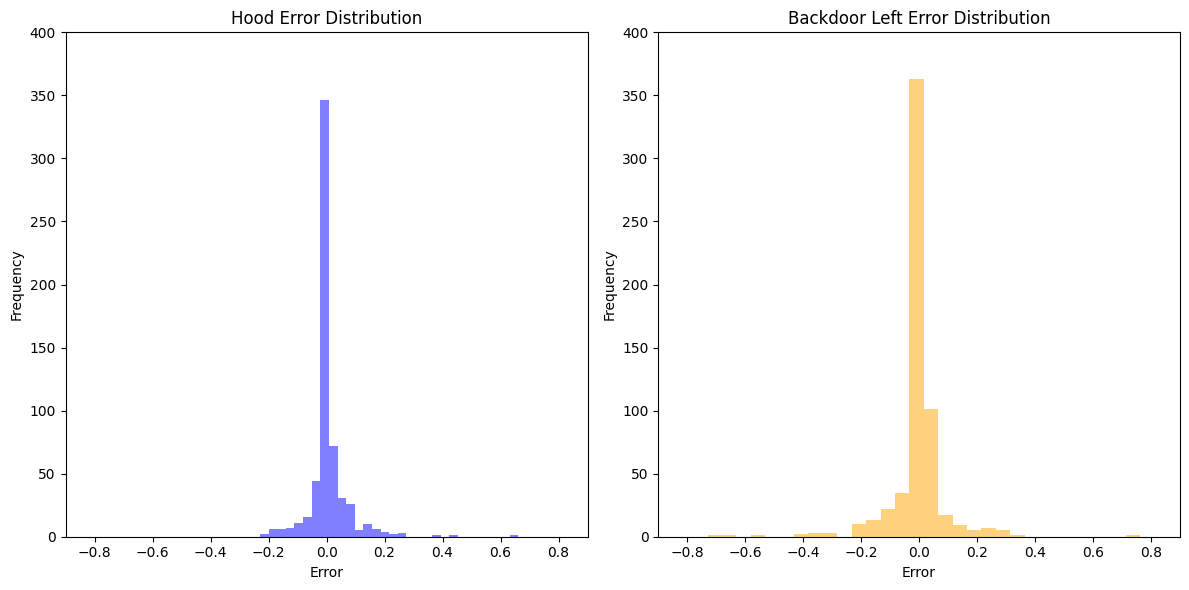

In [24]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(all_outputs[:, 0] - all_labels[:, 0], bins=30, alpha=0.5, label='Hood Error', color='blue')
plt.xlim(-0.9, 0.9)
plt.ylim(0, 400)
plt.title('Hood Error Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(all_outputs[:, 1] - all_labels[:, 1], bins=30, alpha=0.5, label='Backdoor Left Error', color='orange')
plt.xlim(-0.9, 0.9)
plt.ylim(0, 400)
plt.title('Backdoor Left Error Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

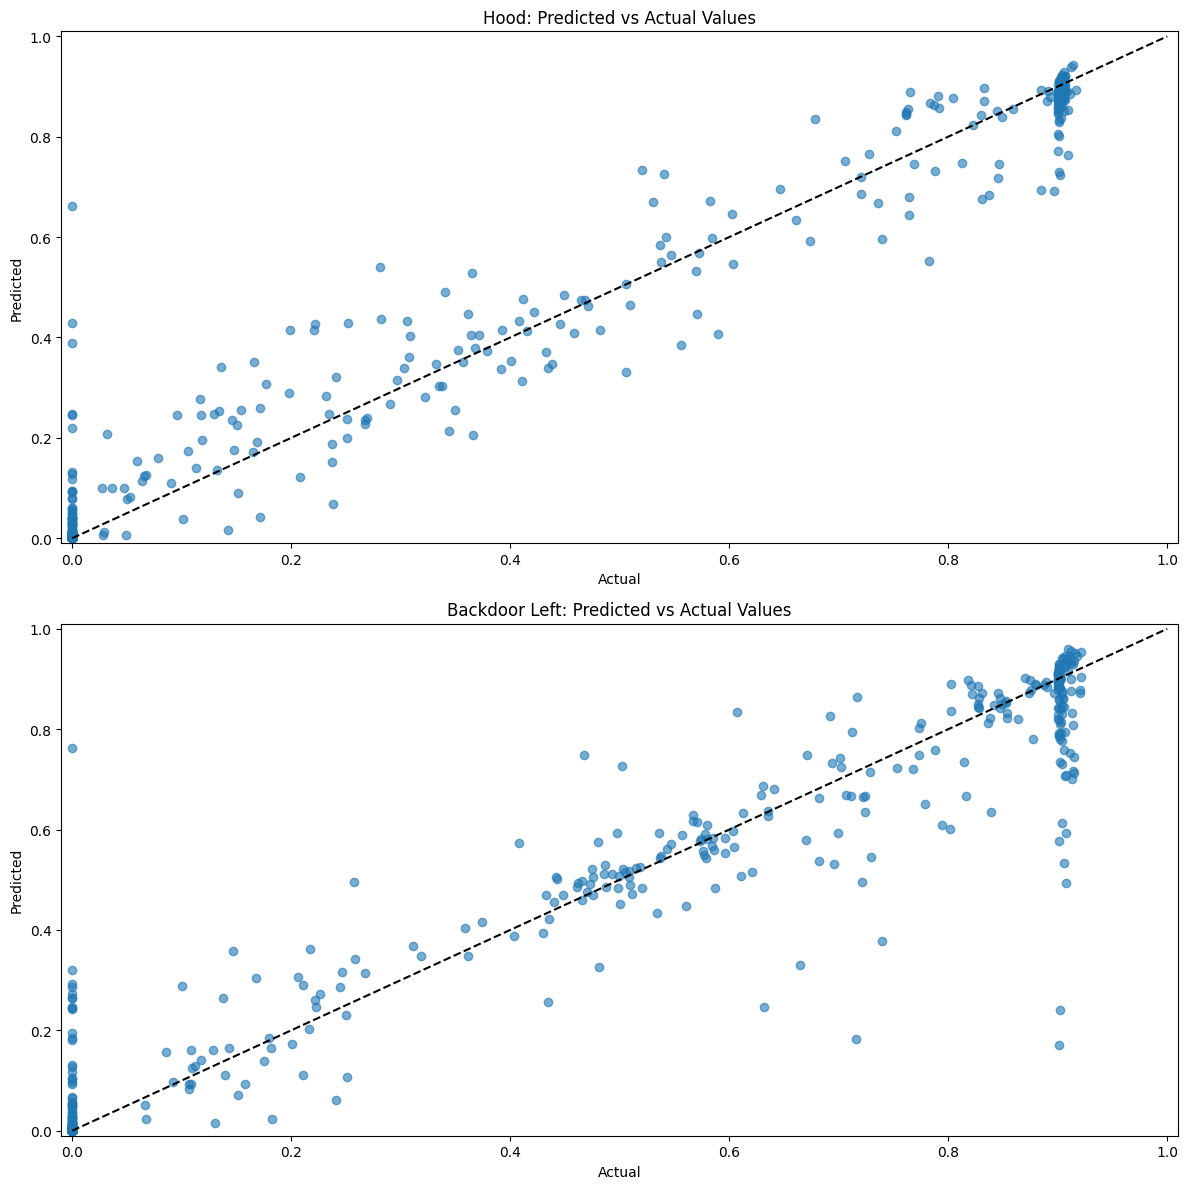

In [25]:
plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
plt.scatter(all_labels[:, 0], all_outputs[:, 0], label='Hood', alpha=0.6)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Hood: Predicted vs Actual Values")

plt.subplot(2, 1, 2)
plt.scatter(all_labels[:, 1], all_outputs[:, 1], label='Backdoor Left', alpha=0.6)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Backdoor Left: Predicted vs Actual Values")

plt.tight_layout()
plt.show()

In [26]:
bins = np.linspace(0, 1, 10)
hood_bin_indices = np.digitize(all_labels[:, 0], bins)
backdoor_left_bin_indices = np.digitize(all_labels[:, 1], bins)
hood_binned_mae = [np.mean(np.abs(all_outputs[hood_bin_indices == i, 0] 
                                  - all_labels[hood_bin_indices == i, 0])) for i in range(1, len(bins))]
backdoor_left_binned_mae = [np.mean(np.abs(all_outputs[backdoor_left_bin_indices == i, 1] 
                                           - all_labels[backdoor_left_bin_indices == i, 1])) for i in range(1, len(bins))]

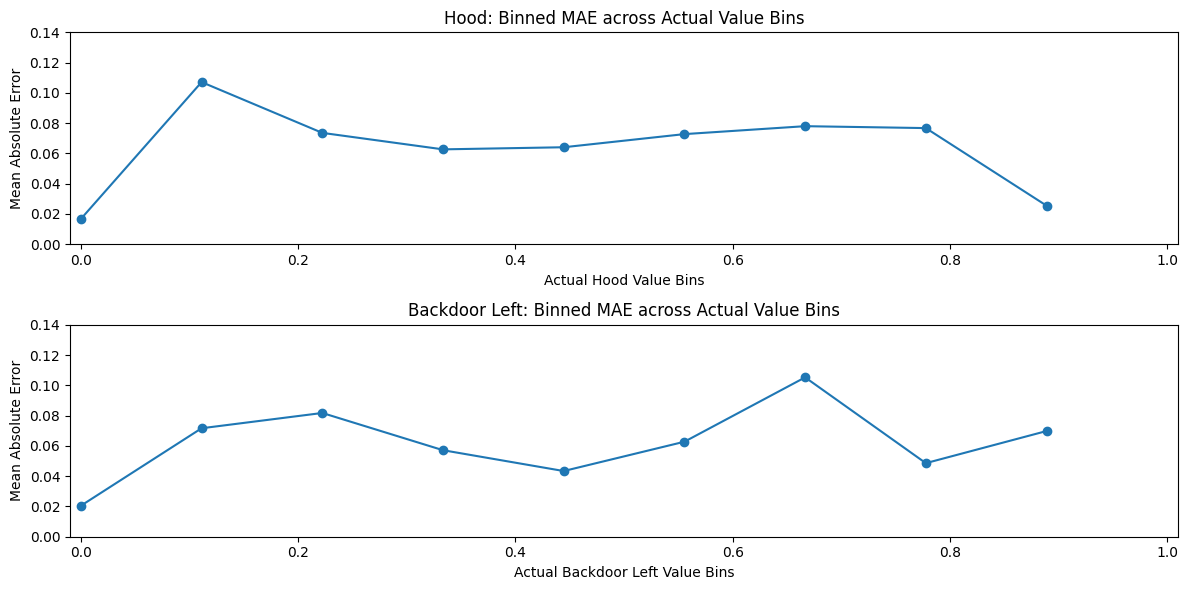

In [27]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(bins[:-1], hood_binned_mae, marker='o', label='Hood Binned MAE')
plt.xlim(-0.01, 1.01)
plt.ylim(0, 0.14)
plt.xlabel('Actual Hood Value Bins')
plt.ylabel('Mean Absolute Error')
plt.title('Hood: Binned MAE across Actual Value Bins')

plt.subplot(2, 1, 2)
plt.plot(bins[:-1], backdoor_left_binned_mae, marker='o', label='Backdoor Left Binned MAE')
plt.xlim(-0.01, 1.01)
plt.ylim(0, 0.14)
plt.xlabel('Actual Backdoor Left Value Bins')
plt.ylabel('Mean Absolute Error')
plt.title('Backdoor Left: Binned MAE across Actual Value Bins')

plt.tight_layout()
plt.show()

In [28]:
def overlay_gradcam_on_image(img, cam):
    cam = np.maximum(cam, 0)
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-10)
    cam = cv2.normalize(src=cam, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    alpha_mask = cam / 255
    alpha_mask_colored = cv2.merge([alpha_mask, alpha_mask, alpha_mask])
    cam = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
    cam = cv2.cvtColor(cam, cv2.COLOR_BGR2RGB)
    #overlay_img = cv2.addWeighted(img, 0.6, cam, 0.4, 0.0)
    overlay_img = (img * (1 - alpha_mask_colored) + cam * alpha_mask_colored).astype(np.uint8)
    return overlay_img

In [41]:
selected_img = 0
last_conv_layer = test_model.features[-2]
layer_gc_hood = LayerGradCam(test_model, last_conv_layer)
layer_gc_backdoor_left = LayerGradCam(test_model, last_conv_layer)
images, labels = next(iter(dataloaders['test']))
images, labels = images.to(device), labels.to(device)
with torch.no_grad():
    output = test_model(images)
attr_hood = layer_gc_hood.attribute(images, target=0)
upsampled_attr_hood = cv2.resize(attr_hood[selected_img].squeeze().detach().cpu().numpy(), 
                                 (input_dim, input_dim), interpolation=cv2.INTER_LANCZOS4)
attr_backdoor_left = layer_gc_backdoor_left.attribute(images, target=1)
upsampled_attr_backdoor_left = cv2.resize(attr_backdoor_left[selected_img].squeeze().detach().cpu().numpy(), 
                                          (input_dim, input_dim), interpolation=cv2.INTER_LANCZOS4)

images = images.numpy()
mean_dataset_numpy = np.array(mean_dataset)
std_dataset_numpy = np.array(std_dataset)
images = images * std_dataset_numpy[None, :, None, None] + mean_dataset_numpy[None, :, None, None]
images = np.clip(images, 0, 1)
images = (images * 255).astype(np.uint8)
images = np.transpose(images, (0, 2, 3, 1))

cam_overlay_hood = overlay_gradcam_on_image(images[selected_img], upsampled_attr_hood)
cam_overlay_backdoor_left = overlay_gradcam_on_image(images[selected_img], upsampled_attr_backdoor_left)

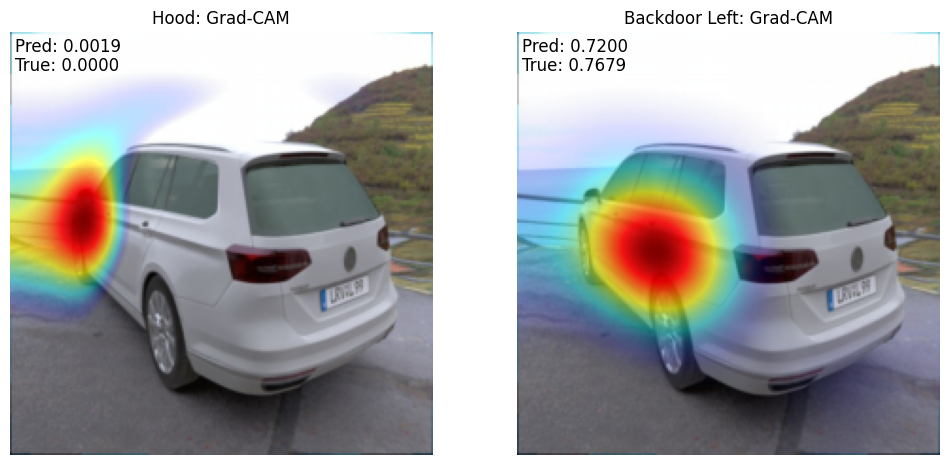

In [42]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(cam_overlay_hood, cmap='jet')
plt.title("Hood: Grad-CAM")
plt.axis('off')
plt.text(2, 10, f'Pred: {output[selected_img][0]:.4f}', color='black', fontsize=12)
plt.text(2, 20, f'True: {labels[selected_img][0].item():.4f}', color='black', fontsize=12)
plt.subplot(1, 2, 2)

plt.imshow(cam_overlay_backdoor_left, cmap='jet')
plt.title("Backdoor Left: Grad-CAM")
plt.axis('off')
plt.text(2, 10, f'Pred: {output[selected_img][1]:.4f}', color='black', fontsize=12)
plt.text(2, 20, f'True: {labels[selected_img][1].item():.4f}', color='black', fontsize=12)

plt.show()

**Weitere Anwendungsfälle**

- Erkennen bzw. Lokalisieren weiterer Bauteile (z. B. Räder, Fenster, Licht, ...)
- Erkennen von Fahrzeugtypen, Automarken, KFZ-Kennzeichen, ...
- Schätzung des Ausmaßes der Schäden sowie einen anschließenden Kostenvoranschlag für die Reperaturen (Auch für Totalschäden)
- Betrugserkennung durch Analysieren der eingereichten Bilder im Laufe der Zeit
- Analysierung der Abnutzung von Fahrzeugen (z. B. für Leasing)
- Fahrzeugqualität nach der Reperatur bestimmen
- Risikoeinschätzung durch Modifikationen am Fahrzeug (z. B. Aufkleber), Wetterverhältnisse, Geographischer Ort
- Rekonstruktion des Unfalls anhand von zur Verfügung stehenden Bildern (ggf. mit Textbeschreibungen)
- Real-Time Insurance mit Smartphone Apps/Virtual Reality Brillen